# BBM Equation Example

Anthony Gruber 3-31-2023

In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import OpInf_utils as ou
import ROM_utils as ru
import KdV_BBM_utils as ku

# To suppress annoying umfpack "almost singular" warnings
import warnings
warnings.filterwarnings('ignore', '.*singular matrix!.*')

## Generate FOM data and POD bases

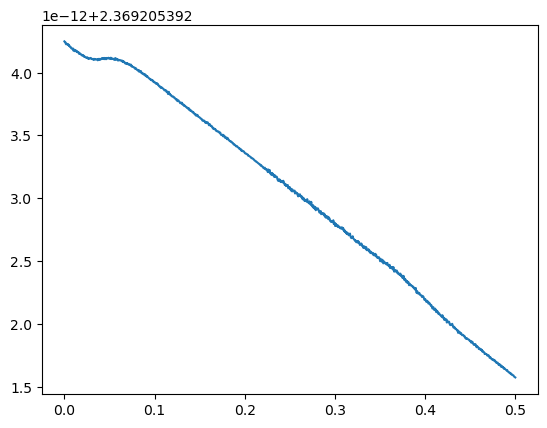

In [2]:
numt   = 1001
T      = 0.5
tTrain = np.linspace(0, T, numt+1)
dt     = tTrain[1] - tTrain[0]

N      = 2**12
xTrain = np.linspace(0, 1, N)
eps    = 0.0001

u_0 = 7/np.cosh(np.sqrt(1/(5*eps))*(xTrain-0.25))**2 + \
      3/np.cosh(np.sqrt(1/(6*eps))*(xTrain-0.35))**2

X = np.zeros((len(u_0), numt+1))
Xdot = np.zeros((len(u_0), numt+1))

u = u_0
X[:,0] = u
for i in range(numt):
    u = ku.BBM_solver(dt, u, y=eps)
    X[:,i+1] = u

Xdot = ou.FDapprox(X.T, dt).T

dx = xTrain[1]-xTrain[0]
plt.plot(tTrain, ku.BBM_Hamil(X, dx))
plt.show()

In [3]:
### Movie of FOM solution

# labs = ['FOM solution']
# styls = ['-']

# ru.animate_array(np.array([X[:,::2]]), styls, labs, xTrain)

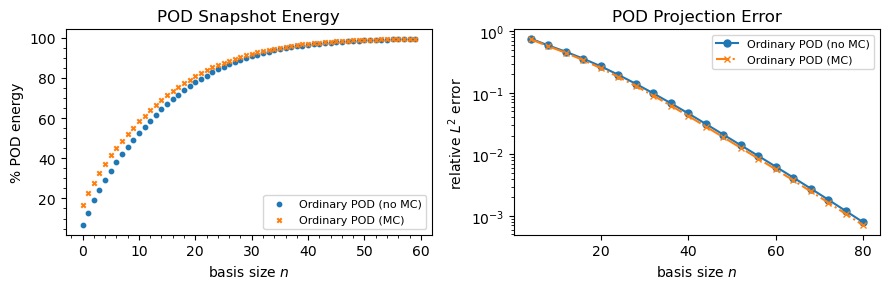

In [4]:
# SVD of mean-centered Snapshot Matrix
ic       = X[:,0]
# ic     = np.zeros((2*N,1))
UU, SS   = np.linalg.svd(X)[:2]
UUmc, SSmc = np.linalg.svd(X-ic.reshape(-1,1))[:2]
OpList    = ku.build_BBM_ROM_ops(UU, ic)
OpListMC  = ku.build_BBM_ROM_ops(UUmc, ic, MC=True)

nEigs = 60
idx = [i for i in range(nEigs)]

nList = [4*(i+1) for i in range(20)]
errUr  = np.zeros(len(nList))
errU2r = np.zeros(len(nList))
errUp  = np.zeros(len(nList))
errU2p = np.zeros(len(nList))
for i,n in enumerate(nList):
    Umc      = UUmc[:,:n]
    U       = UU[:,:n]
    reconU   = ic.reshape(-1,1) + Umc @ Umc.T @ (X - ic.reshape(-1,1))
    reconU2  = U @ U.T @ X
    errUr[i]  = ru.relError(X, reconU)
    errU2r[i] = ru.relError(X, reconU2)

from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].scatter(idx, np.cumsum(SS[:nEigs] / np.sum(SS))*100, s=10, label='Ordinary POD (no MC)')
ax[0].scatter(idx, np.cumsum(SSmc[:nEigs] / np.sum(SSmc))*100, s=10, label='Ordinary POD (MC)', marker='x')
ax[0].set_title('POD Snapshot Energy')
ax[1].semilogy(nList, errU2r, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5)
ax[1].semilogy(nList, errUr, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5)
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
    ax[i].legend(prop={'size': 8})
plt.tight_layout()
# plt.savefig('BBMpodEnergy', transparent=True)
plt.show()

## Compute ROMs 

### Reproductive case

the relative L2 errors for NC-H-OpInf (MC) are [1.89043479e+00 3.54329931e+06 1.69635332e+00 1.32868816e+00
 1.17390390e+00 1.00354131e+00 7.71936608e-01 5.53476383e-01
 3.82134337e-01 2.34055377e-01 1.46330649e-01 9.77847052e-02
 6.67753228e-02 4.79689601e-02 3.73814150e-02 3.20347812e-02
 2.93138868e-02 2.79272266e-02]
the relative L2 errors for NC-H-OpInf (no MC) are [1.06544148 0.97093033 1.05121427 1.31307758 1.26647644 1.16891782
 1.0450943  0.86373079 0.69511515 0.41363847 0.23950585 0.15465702
 0.09946101 0.06872288 0.04701085 0.03630594 0.03189053 0.02915185]
the relative L2 errors for G-OpInf (MC) are [1.98045043e+00 2.33375438e+06 1.70199676e+00 1.32341755e+00
 1.17469201e+00 1.01084622e+00 7.91044130e-01 5.79892314e-01
 4.12366775e-01 2.65485029e-01 1.77654523e-01 1.27854567e-01
 9.50601600e-02 7.49571830e-02 6.28626928e-02 5.63375987e-02
 5.26349657e-02 5.04012839e-02]
the relative L2 errors for G-OpInf (no MC) are [1.06543736 0.97096943 1.05133737 1.31282362 1.26667629 1.

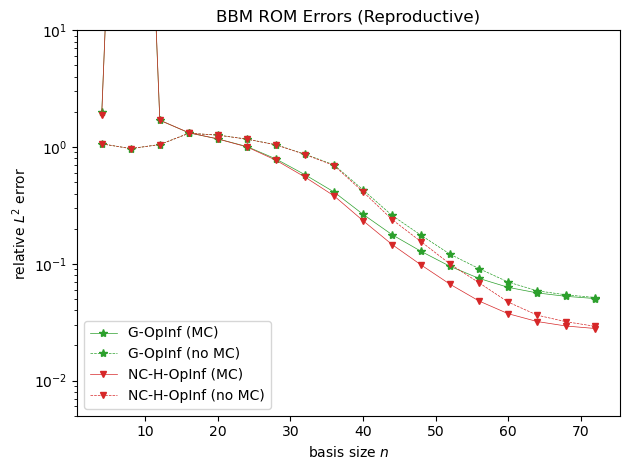

In [5]:
tTest = tTrain
Xtest = X
NtTest = len(tTest)

gradH    = X + X**2/2
gradHhat = UU[:,:150].T @ gradH
XdotHat  = UU[:,:150].T @ Xdot
rhsG     = gradHhat @ XdotHat.T
ghghT    = gradHhat @ gradHhat.T

gradHhat = UUmc[:,:150].T @ gradH
XdotHat  = UUmc[:,:150].T @ Xdot
rhsGmc   = gradHhat @ XdotHat.T
ghghTmc  = gradHhat @ gradHhat.T


nList   = [4*(i+1) for i in range(18)]
eOp     = np.zeros(len(nList))
eOpMC   = np.zeros(len(nList))
eHOp    = np.zeros(len(nList))
eHOpMC  = np.zeros(len(nList))

XrecHOp    = np.zeros((len(nList), N, NtTest))
XrecHOpMC  = np.zeros((len(nList), N, NtTest))
XrecOp     = np.zeros((len(nList), N, NtTest))
XrecOpMC   = np.zeros((len(nList), N, NtTest))

oneShot = True
_ = np.random.rand(UU.shape[0],UU.shape[0])

OpInfLists   = ou.build_OpInf_stuff(UU, X, Xdot, gradH, _, nList[-1])
OpInfListMC = ou.build_OpInf_stuff(UUmc, X, Xdot, gradH, _, nList[-1], MC=True)

if oneShot:
    LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=0.0e-12)
    LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=0.0e-12)

# DhatOpFull = ou.G_OpInf(OpInfLists[-1], nList[-1], SS1, eps=1.0e-15)
DhatOpFull   = ou.G_OpInf([ghghT, rhsG], nList[-1], eps=0e-5)
DhatOpFullMC = ou.G_OpInf([ghghTmc, rhsGmc], nList[-1], eps=0e-5)


for i,n in enumerate(nList):

    if oneShot:
        LhatHOp   = LhatHOpFull[:n,:n]
        LhatHOpMC = LhatHOpFullMC[:n,:n]
    else:
        LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=0.0e-12)
        LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=0.0e-12)    
    
    DhatOp   = DhatOpFull[:n,:n]
    DhatOpMC = DhatOpFullMC[:n,:n]
    # DhatOpFull  = ou.G_OpInf([ghghT, rhsG], n, eps=1e-12)

    OpList[-1]   = LhatHOp
    OpListMC[-1] = LhatHOpMC

    XrecHOpMC[i]  = ku.integrate_KdV_v1_ROM(tTest, OpListMC, ic, UUmc, n,
                                            Hamiltonian=True, MC=True, Newton=True)
    XrecHOp[i]    = ku.integrate_KdV_v1_ROM(tTest, OpList, ic, UU, n,
                                            Hamiltonian=True, MC=False, Newton=True)
    # XrecOp    = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UU1)
    OpList[-1]   = DhatOp
    OpListMC[-1] = DhatOpMC
    XrecOp[i]    = ku.integrate_KdV_v1_ROM(tTest, OpList, ic, UU, n,
                                           Hamiltonian=True, MC=False, Newton=True)
    XrecOpMC[i]  = ku.integrate_KdV_v1_ROM(tTest, OpListMC, ic, UUmc, n,
                                           Hamiltonian=True, MC=True, Newton=True)

    eHOp[i]    = ru.relError(Xtest, XrecHOp[i])
    eHOpMC[i]  = ru.relError(Xtest, XrecHOpMC[i])
    eOp[i]     = ru.relError(Xtest, XrecOp[i])
    eOpMC[i]   = ru.relError(Xtest, XrecOpMC[i])

# Print error magnitudes
print(f'the relative L2 errors for NC-H-OpInf (MC) are {eHOpMC}')
print(f'the relative L2 errors for NC-H-OpInf (no MC) are {eHOp}')
print(f'the relative L2 errors for G-OpInf (MC) are {eOpMC}')
print(f'the relative L2 errors for G-OpInf (no MC) are {eOp}')

name = "tab10"
cmap = plt.get_cmap(name)

plt.semilogy(nList, eOpMC, label='G-OpInf (MC)',
             marker='*', linestyle='-', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.semilogy(nList, eOp,  label='G-OpInf (no MC)',
             marker='*', linestyle='--', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.semilogy(nList, eHOpMC, label='NC-H-OpInf (MC)',
             marker='v', linestyle='-', color=cmap.colors[3], linewidth=0.5, markersize=5)
plt.semilogy(nList, eHOp, label='NC-H-OpInf (no MC)',
             marker='v', linestyle='--', color=cmap.colors[3], linewidth=0.5, markersize=5)
plt.ylabel('relative $L^2$ error')
plt.xlabel('basis size $n$')
plt.title('BBM ROM Errors (Reproductive)')
plt.ylim([5*10**-3,10.])
plt.legend(loc=3)

plt.tight_layout()
# plt.savefig(f'BBMPlotTrepr.png', transparent=True)
plt.show()

### Compute ROMs in predictive case

the relative L2 errors for NC-H-OpInf (MC) are [9.75540665e+04 2.61474905e+06 1.99123199e+05 8.75305265e+04
 1.38286007e+00 1.23115844e+00 1.08552209e+00 9.25201711e-01
 7.57538199e-01 5.47941226e-01 4.06144752e-01 3.25707159e-01
 2.71489968e-01 2.37901711e-01 2.18938528e-01 2.09917052e-01
 2.05302916e-01 2.03050080e-01]
the relative L2 errors for NC-H-OpInf (no MC) are [1.11494801e+00 1.09491605e+00 1.22341611e+00 1.53804313e+07
 1.37468161e+00 1.29367651e+00 1.21160076e+00 1.09194804e+00
 1.01107583e+00 7.95702792e-01 5.60999576e-01 4.26785493e-01
 3.30950050e-01 2.75933913e-01 2.36240138e-01 2.17489037e-01
 2.10120801e-01 2.05337752e-01]
the relative L2 errors for G-OpInf (MC) are [6.35586369e+04 5.56955408e+06 2.64400104e+05 4.31703983e+04
 1.36112327e+00 1.23131781e+00 1.09657999e+00 9.54829036e-01
 7.96398545e-01 6.01909720e-01 4.64529001e-01 3.82593566e-01
 3.24340184e-01 2.85176766e-01 2.60724694e-01 2.48048137e-01
 2.40423771e-01 2.35212543e-01]
the relative L2 errors for G-Op

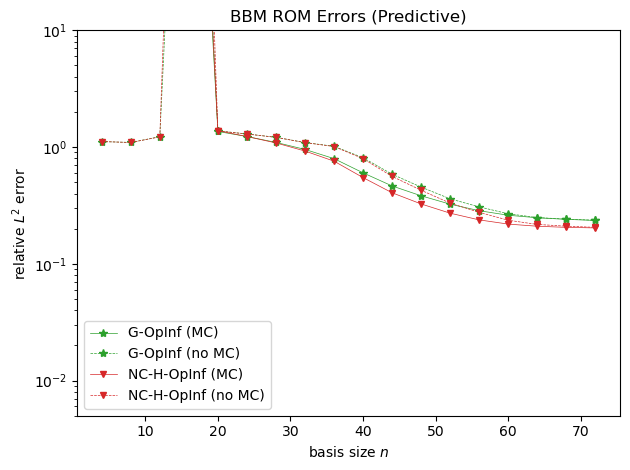

In [6]:
# tTest = tTrain
# Xtest = X
# NtTest = len(tTest)

numtTest = 1001
tTest  = np.linspace(0,2.0*T,numtTest+1)
dtTest = tTest[1]-tTest[0]
NtTest = len(tTest)
Xtest  = np.zeros_like(X)
u = u_0
Xtest[:,0] = u
for i in range(numtTest):
    u = ku.BBM_solver(dtTest, u, y=eps)
    Xtest[:,i+1] = u

gradH    = X + X**2/2
gradHhat = UU[:,:150].T @ gradH
XdotHat  = UU[:,:150].T @ Xdot
rhsG     = gradHhat @ XdotHat.T
ghghT    = gradHhat @ gradHhat.T

gradHhat = UUmc[:,:150].T @ gradH
XdotHat  = UUmc[:,:150].T @ Xdot
rhsGmc   = gradHhat @ XdotHat.T
ghghTmc  = gradHhat @ gradHhat.T


nList   = [4*(i+1) for i in range(18)]
eOp     = np.zeros(len(nList))
eOpMC   = np.zeros(len(nList))
eHOp    = np.zeros(len(nList))
eHOpMC  = np.zeros(len(nList))

XrecHOp    = np.zeros((len(nList), N, NtTest))
XrecHOpMC  = np.zeros((len(nList), N, NtTest))
XrecOp     = np.zeros((len(nList), N, NtTest))
XrecOpMC   = np.zeros((len(nList), N, NtTest))

oneShot = True
_ = np.random.rand(UU.shape[0],UU.shape[0])

OpInfLists   = ou.build_OpInf_stuff(UU, X, Xdot, gradH, _, nList[-1])
OpInfListMC = ou.build_OpInf_stuff(UUmc, X, Xdot, gradH, _, nList[-1], MC=True)

if oneShot:
    LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=0.0e-12)
    LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=0.0e-12)

# DhatOpFull = ou.G_OpInf(OpInfLists[-1], nList[-1], SS1, eps=1.0e-15)
DhatOpFull   = ou.G_OpInf([ghghT, rhsG], nList[-1], eps=0e-5)
DhatOpFullMC = ou.G_OpInf([ghghTmc, rhsGmc], nList[-1], eps=0e-5)


for i,n in enumerate(nList):

    if oneShot:
        LhatHOp   = LhatHOpFull[:n,:n]
        LhatHOpMC = LhatHOpFullMC[:n,:n]
    else:
        LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=0.0e-12)
        LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=0.0e-12)    
    
    DhatOp   = DhatOpFull[:n,:n]
    DhatOpMC = DhatOpFullMC[:n,:n]
    # DhatOpFull  = ou.G_OpInf([ghghT, rhsG], n, eps=1e-12)

    OpList[-1]   = LhatHOp
    OpListMC[-1] = LhatHOpMC

    XrecHOpMC[i]  = ku.integrate_KdV_v1_ROM(tTest, OpListMC, ic, UUmc, n,
                                            Hamiltonian=True, MC=True, Newton=True)
    XrecHOp[i]    = ku.integrate_KdV_v1_ROM(tTest, OpList, ic, UU, n,
                                            Hamiltonian=True, MC=False, Newton=True)
    # XrecOp    = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UU1)
    OpList[-1]   = DhatOp
    OpListMC[-1] = DhatOpMC
    XrecOp[i]    = ku.integrate_KdV_v1_ROM(tTest, OpList, ic, UU, n,
                                           Hamiltonian=True, MC=False, Newton=True)
    XrecOpMC[i]  = ku.integrate_KdV_v1_ROM(tTest, OpListMC, ic, UUmc, n,
                                           Hamiltonian=True, MC=True, Newton=True)

    eHOp[i]    = ru.relError(Xtest, XrecHOp[i])
    eHOpMC[i]  = ru.relError(Xtest, XrecHOpMC[i])
    eOp[i]     = ru.relError(Xtest, XrecOp[i])
    eOpMC[i]   = ru.relError(Xtest, XrecOpMC[i])

# Print error magnitudes
print(f'the relative L2 errors for NC-H-OpInf (MC) are {eHOpMC}')
print(f'the relative L2 errors for NC-H-OpInf (no MC) are {eHOp}')
print(f'the relative L2 errors for G-OpInf (MC) are {eOpMC}')
print(f'the relative L2 errors for G-OpInf (no MC) are {eOp}')

name = "tab10"
cmap = plt.get_cmap(name)

plt.semilogy(nList, eOpMC, label='G-OpInf (MC)',
             marker='*', linestyle='-', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.semilogy(nList, eOp,  label='G-OpInf (no MC)',
             marker='*', linestyle='--', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.semilogy(nList, eHOpMC, label='NC-H-OpInf (MC)',
             marker='v', linestyle='-', color=cmap.colors[3], linewidth=0.5, markersize=5)
plt.semilogy(nList, eHOp, label='NC-H-OpInf (no MC)',
             marker='v', linestyle='--', color=cmap.colors[3], linewidth=0.5, markersize=5)
plt.ylabel('relative $L^2$ error')
plt.xlabel('basis size $n$')
plt.title('BBM ROM Errors (Predictive)')
plt.ylim([5*10**-3,10.])
plt.legend(loc=3)

plt.tight_layout()
# plt.savefig(f'BBMPlotTpred.png', transparent=True)
plt.show()

### Make movie of solution

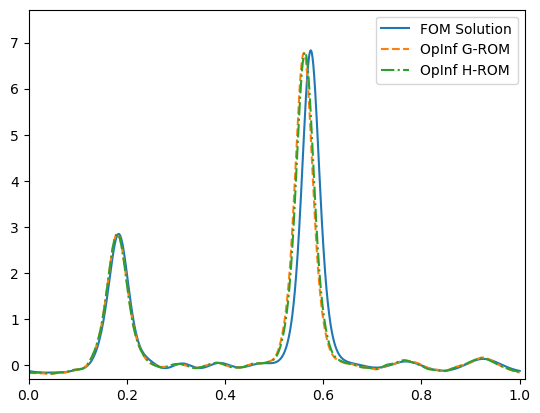

In [7]:
i=14

arrs = np.stack([Xtest,
                 XrecOpMC[i], XrecHOpMC[i]], axis=0)

styles = ['-', '--', '-.']
labels = ['FOM Solution', 'OpInf G-ROM', 'OpInf H-ROM']

ru.animate_array(arrs, styles, labels, xTrain)

### Plots of solution and conserved quantities

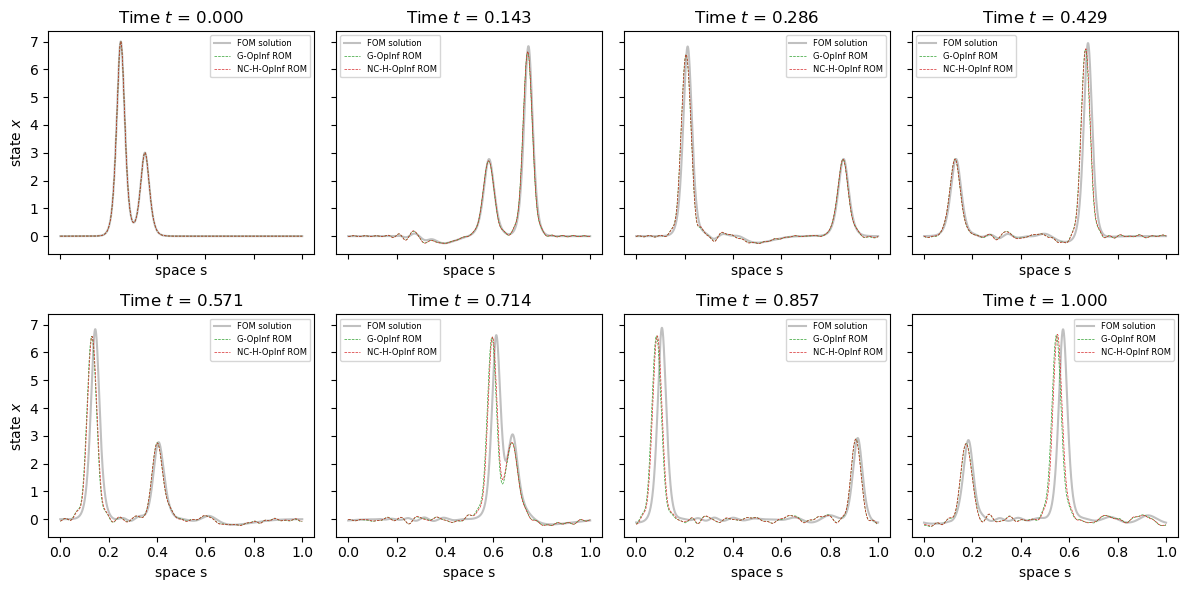

the times are [0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]


/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_91088/2418414007.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


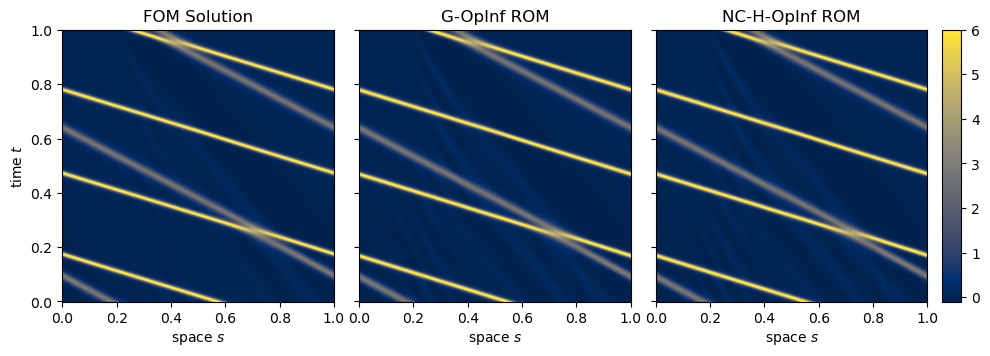

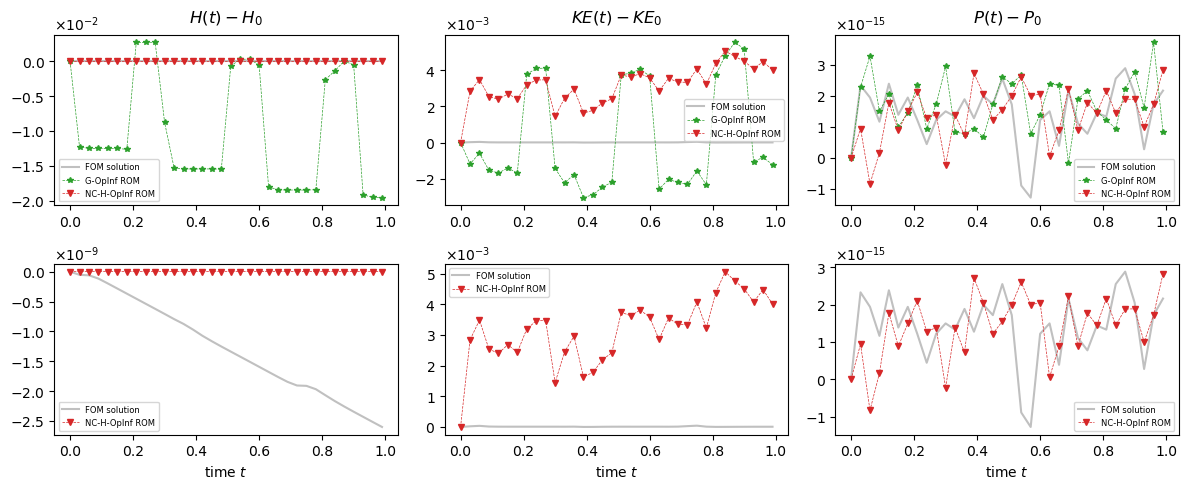

In [10]:
i=10

name = "tab10"
cmap = plt.get_cmap(name)

fig, ax = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)

ax.flatten()[0].set_ylabel(f'state $x$')
ax.flatten()[4].set_ylabel(f'state $x$')

tList = [int(np.ceil(1001/7*i)) for i in range(8)]
# tList = [0, 85, 300, 600]
for l,t in enumerate(tList):
    ax.flatten()[l].plot(xTrain, Xtest[:,t], label='FOM solution', color='silver', linestyle='-')
    ax.flatten()[l].plot(xTrain, XrecOpMC[i][:,t], label='G-OpInf ROM', color=cmap.colors[2], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecHOpMC[i][:,t], label='NC-H-OpInf ROM', color=cmap.colors[3], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].set_title(f'Time $t$ = {t/1001:.3f}')
    ax.flatten()[l].set_xlabel(f'space s')

    ax.flatten()[l].legend(prop={'size':6})
plt.tight_layout()
# plt.savefig(f'BBMsoln{4*(i+1)}ModesPred', transparent=True)
plt.show()

print(f'the times are {tTest[tList]}')


i=10
dx = xTrain[1]-xTrain[0]
dt = tTest[1]-tTest[0]
extent = [xTrain[0]-dx, xTrain[-1]+dx, tTest[0]-dt, tTest[-1]+dt]

titleList = ['FOM Solution', 'G-OpInf ROM', 'NC-H-OpInf ROM']

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10,4))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

im = grid[0].imshow(Xtest.T, extent=extent, cmap='cividis', vmin=-0.1, vmax=6.)
im = grid[1].imshow(XrecOpMC[i].T, extent=extent, cmap='cividis', vmin=-0.1, vmax=6.)
im = grid[2].imshow(XrecHOpMC[i].T, extent=extent, cmap='cividis', vmin=-0.1, vmax=6.)
for j in range(3):
    grid[j].set_title(f'{titleList[j]}')
    grid[j].set_xlabel('space $s$')
grid[0].set_ylabel('time $t$')

grid[-1].cax.colorbar(im)
grid[-1].cax.toggle_label(True)

plt.tight_layout()
# plt.savefig(f'BBMimshow{4*(i+1)}ModesTpred', transparent=True, bbox_inches='tight')
plt.show()



i=10
fig, ax = plt.subplots(2, 3, figsize=(12,5))

A, B, E     = ku.build_KdV_mats(N, [0,1])
titleList   = [r'$H(t) - H_0$', r'$KE(t) - KE_0$', r'$P(t) - P_0$',]

exact   = ku.BBM_Hamil(Xtest, dx)
Op  = ku.BBM_Hamil(XrecOpMC[i], dx)
OpH = ku.BBM_Hamil(XrecHOpMC[i], dx)

exact-= exact[0]
Op -= Op[0]
OpH -= OpH[0]

skip=30

ax[0,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,0].plot(tTest[::skip], Op[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], OpH[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,0].plot(tTest[::skip], OpH[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)

exact   = ku.BBM_KinE(Xtest, dx, y=eps)
Op  = ku.BBM_KinE(XrecOpMC[i], dx, y=eps)
OpH = ku.BBM_KinE(XrecHOpMC[i], dx, y=eps)

exact-= exact[0]
Op -= Op[0]
OpH -= OpH[0]


ax[0,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,1].plot(tTest[::skip], Op[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], OpH[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,1].plot(tTest[::skip], OpH[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)

exact   = ku.BBM_momentum(Xtest, B, dx, y=eps)
Op  = ku.BBM_momentum(XrecOpMC[i], B, dx, y=eps)
OpH = ku.BBM_momentum(XrecHOpMC[i], B, dx, y=eps)

exact-= exact[0]
Op -= Op[0]
OpH -= OpH[0]

ax[0,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,2].plot(tTest[::skip], Op[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[0,2].plot(tTest[::skip], OpH[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,2].plot(tTest[::skip], OpH[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)

for j in range(6):
    ax.flatten()[j].legend(prop={'size':6})
    ax.flatten()[j].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
for j in range(3):
    ax[0,j].set_title(f'{titleList[j]}', loc='center', y=1.02)
    ax[-1,j].set_xlabel('time $t$')

plt.tight_layout()
# plt.savefig(f'BBMEnergy{4*(i+1)}modesTpred', transparent=True)
plt.show()